In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from tensorflow import keras

from keras import layers
from keras import losses

from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

2023-10-25 13:53:34.755955: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 13:53:34.803264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 13:53:35.036305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 13:53:35.036357: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 13:53:35.037851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:



data = pd.read_csv('./Data/Final_eskom_vector_grid_health.csv')
data = pd.DataFrame(data)
data['Time'] = pd.to_datetime(data['DateTime'])
data.set_index('Time', inplace=True)




/tmp/ipykernel_6882/918728505.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['DateTime'])


In [22]:

# split_date = '2022-03-01'
# train = data[data.index < split_date]
# test = data[data.index >= split_date]




(26918, 15)

### Train test split

In [3]:



Y_columns = [
    'ILS Usage',
    'MLR', 'IOS Excl ILS and MLR',
     'Total UCLF+OCLF'
]
Y = data[Y_columns].values
X = data.drop(columns=Y_columns, axis=1)
X.drop(['DateTime'], axis =1, inplace = True)
X = X.values

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.10, shuffle=False, random_state=42)

# Then, split the temporary test set into validation (50%) and final test (50%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.10, shuffle=False, random_state=42)

# Print the shapes of the resulting sets
print("Training set (X_train, Y_train) shapes:", X_train.shape, Y_train.shape)
print("Validation set (X_val, Y_val) shapes:", X_val.shape, Y_val.shape)
print("Test set (X_test, Y_test) shapes:", X_test.shape, Y_test.shape)

Training set (X_train, Y_train) shapes: (27254, 15) (27254, 4)
Validation set (X_val, Y_val) shapes: (3029, 15) (3029, 4)
Test set (X_test, Y_test) shapes: (3365, 15) (3365, 4)


In [4]:
# Y_columns = [
#     'ILS Usage',
#     'MLR', 'IOS Excl ILS and MLR',
#      'Total UCLF+OCLF'
# ]
# Y_train = train[Y_columns].values
# X_train = train.drop(columns=Y_columns, axis=1)
# X_train.drop(['DateTime'], axis =1, inplace = True)
# X_train = X_train.values

# Y_test = test[Y_columns].values
# X_test = test.drop(columns=Y_columns, axis=1)
# X_test.drop(['DateTime'], axis =1, inplace = True)
# X_test = X_test.values

### Standardising the input values

In [4]:
scaler = StandardScaler()
X_train_normalised = scaler.fit_transform(X_train)
X_test_normalised = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

Y_train_normalised = scaler.fit_transform(Y_train)
Y_test_normalised = scaler.transform(Y_test)
Y_val_norm = scaler.transform(Y_val)

### Putting into sequence of weeks (window length)

In [30]:
# # split a multivariate sequence into samples
# def split_multivar_sequences(sequenceX, sequenceY, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequenceX)):
#         # find the end of this pattern
#         end_idx = i + n_steps
#         # check if we are beyond the dataset
#         if end_idx > len(sequenceY)-1:
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = sequenceX[i:end_idx, :], sequenceY[end_idx]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

# timesteps = 24*7
# X_train_seq_weeks, Y_train_seq_weeks = split_multivar_sequences(X_train_normalised, Y_train_normalised, timesteps)
# X_test_seq_weeks, Y_test_seq_weeks = split_multivar_sequences(X_test_normalised, Y_test_normalised, timesteps)



In [5]:
timesteps = 24*7
window_length = timesteps
batch_size = 16
num_features = 15
train_generator = TimeseriesGenerator(X_train_normalised, Y_train_normalised,length=window_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_normalised, Y_test_normalised,length=window_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_norm, Y_val_norm, length=window_length, batch_size=batch_size)

In [13]:
(train_generator)

<function TimeseriesGenerator.__sizeof__()>

In [9]:
# print('(n_samples, n_steps, n_features)')
# print(f'Shape of X: {(X_train_seq_weeks).shape}')
# print(f'Shape of Y: {(Y_train_seq_weeks).shape}')


# print(f'Shape of X: {(X_test_seq_weeks).shape}')
# print(f'Shape of Y: {(Y_test_seq_weeks).shape}')

(n_samples, n_steps, n_features)
Shape of X: (25392, 168, 15)
Shape of Y: (25392, 4)
Shape of X: (7920, 168, 15)
Shape of Y: (7920, 4)


# Model Building (Single LTSM 32 Units)

In [59]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=False, activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                6144      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6276 (24.52 KB)
Trainable params: 6276 (24.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
history = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)


Epoch 1/5
1693/1693 [==============================] - 37s 21ms/step - loss: 0.8364 - mean_absolute_error: 0.4502 - val_loss: 1.3293 - val_mean_absolute_error: 0.6123
Epoch 2/5
1693/1693 [==============================] - 39s 23ms/step - loss: 0.6947 - mean_absolute_error: 0.3922 - val_loss: 1.4101 - val_mean_absolute_error: 0.6420
Epoch 3/5
1693/1693 [==============================] - 40s 23ms/step - loss: 0.6351 - mean_absolute_error: 0.3674 - val_loss: 1.2203 - val_mean_absolute_error: 0.5993
Epoch 4/5
1693/1693 [==============================] - 40s 23ms/step - loss: 0.5986 - mean_absolute_error: 0.3544 - val_loss: 1.1636 - val_mean_absolute_error: 0.5692
Epoch 5/5
1693/1693 [==============================] - 40s 24ms/step - loss: 0.5815 - mean_absolute_error: 0.3422 - val_loss: 1.0879 - val_mean_absolute_error: 0.5586


## Bidirectional LTSM 32 Units

In [62]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=False, activation='tanh')),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 64)                12288     
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12548 (49.02 KB)
Trainable params: 12548 (49.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
bi_history = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/5
1693/1693 [==============================] - 57s 32ms/step - loss: 0.8005 - mean_absolute_error: 0.4499 - val_loss: 1.5454 - val_mean_absolute_error: 0.6923
Epoch 2/5
1693/1693 [==============================] - 61s 36ms/step - loss: 0.6590 - mean_absolute_error: 0.3898 - val_loss: 1.2863 - val_mean_absolute_error: 0.6235
Epoch 3/5
1693/1693 [==============================] - 61s 36ms/step - loss: 0.5990 - mean_absolute_error: 0.3625 - val_loss: 1.1672 - val_mean_absolute_error: 0.6052
Epoch 4/5
1693/1693 [==============================] - 60s 36ms/step - loss: 0.5696 - mean_absolute_error: 0.3472 - val_loss: 1.0568 - val_mean_absolute_error: 0.5923
Epoch 5/5
1693/1693 [==============================] - 66s 39ms/step - loss: 0.5405 - mean_absolute_error: 0.3329 - val_loss: 1.1453 - val_mean_absolute_error: 0.6261


### Deep model standard LTSM

In [66]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh'),
  layers.Dropout(0.2),
  layers.LSTM(32, input_shape = (window_length, 15)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 168, 32)           6144      
                                                                 
 dropout_10 (Dropout)        (None, 168, 32)           0         
                                                                 
 lstm_12 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14596 (57.02 KB)
Trainable params: 14596 (57.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
deep_history = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/5
1693/1693 [==============================] - 89s 51ms/step - loss: 0.8046 - mean_absolute_error: 0.4224 - val_loss: 1.4161 - val_mean_absolute_error: 0.5997
Epoch 2/5
1693/1693 [==============================] - 94s 55ms/step - loss: 0.6874 - mean_absolute_error: 0.3712 - val_loss: 1.0877 - val_mean_absolute_error: 0.5218
Epoch 3/5
1693/1693 [==============================] - 95s 56ms/step - loss: 0.6317 - mean_absolute_error: 0.3479 - val_loss: 1.1016 - val_mean_absolute_error: 0.5276
Epoch 4/5
1693/1693 [==============================] - 89s 53ms/step - loss: 0.5823 - mean_absolute_error: 0.3280 - val_loss: 1.0130 - val_mean_absolute_error: 0.5241
Epoch 5/5
1693/1693 [==============================] - 108s 64ms/step - loss: 0.5682 - mean_absolute_error: 0.3239 - val_loss: 0.9596 - val_mean_absolute_error: 0.4839


### Deep model bi directional LTSM

In [68]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(32, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(
  layers.LSTM(32,  return_sequences=False)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 168, 64)           12288     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 168, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 37380 (146.02 KB)
Trainable params: 3738

In [69]:
deep_history_bi = model.fit(train_generator, epochs=5, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Epoch 1/5
1693/1693 [==============================] - 142s 81ms/step - loss: 0.7776 - mean_absolute_error: 0.4286 - val_loss: 1.6222 - val_mean_absolute_error: 0.6613
Epoch 2/5
1693/1693 [==============================] - 137s 81ms/step - loss: 0.6329 - mean_absolute_error: 0.3670 - val_loss: 1.1727 - val_mean_absolute_error: 0.5813
Epoch 3/5
1693/1693 [==============================] - 145s 86ms/step - loss: 0.5717 - mean_absolute_error: 0.3325 - val_loss: 1.0787 - val_mean_absolute_error: 0.5646
Epoch 4/5
1693/1693 [==============================] - 142s 84ms/step - loss: 0.5222 - mean_absolute_error: 0.3114 - val_loss: 0.9722 - val_mean_absolute_error: 0.5279
Epoch 5/5
1693/1693 [==============================] - 146s 86ms/step - loss: 0.4953 - mean_absolute_error: 0.3030 - val_loss: 1.0038 - val_mean_absolute_error: 0.5241


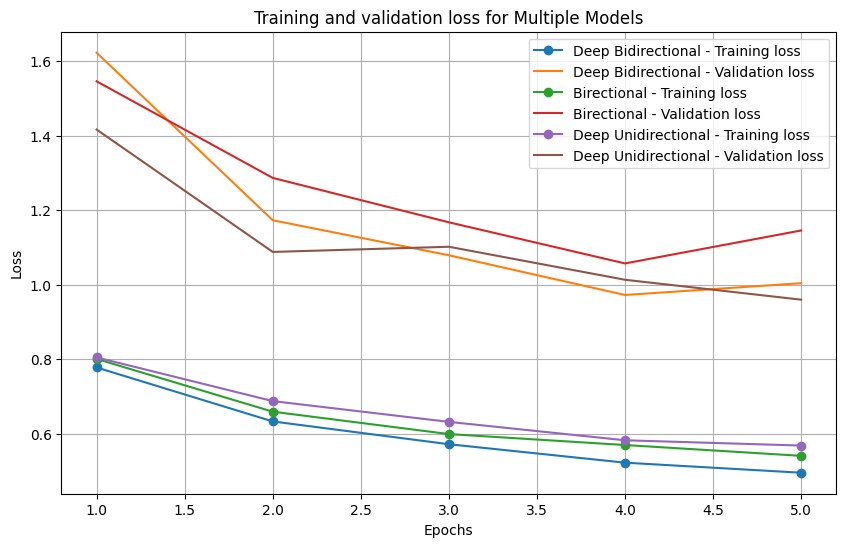

In [76]:
history_dicts = [deep_history_bi.history, history.history, deep_history.history]

# Define labels for each model
model_labels = ['Deep Bidirectional', 'Birectional', 'Deep Unidirectional']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['mean_absolute_error']
    val_error = history_dict['val_mean_absolute_error']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')
    
    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


## Model making

### Deep bidirectional with more epochs and more units

In [79]:
patience = 2 #num epochs without improvement

model = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(window_length, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(
  layers.LSTM(32,  return_sequences=False)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model.build((None, timesteps, 15))
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 168, 128)          40960     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 168, 128)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 82436 (322.02 KB)
Trainable params: 824

In [ ]:
model_history = model.fit(train_generator, epochs=100, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)